## Clasificador de Noticias Argentinas 

In [1]:
import pandas as pd

df = pd.read_excel('../../res/tp1/Noticias_argentinas.xlsx', sheet_name='aa_bayes')

In [2]:
# Nos quedamos con los atributos de interes

df = df[["titular", "categoria"]]

# removemos las categorias que no necesitamos ('Destacadas', 'Noticias Destacadas')


df.head()

,titular,categoria
0,Trabajadores del Buenos Aires Design cortan la...,Nacional
1,La boda del gobernador Gerardo Morales: tapas ...,Nacional
2,Cumbre del G20: qué calles estarán cortadas y ...,Nacional
3,Una fractura que confirma la candidatura de Cr...,Nacional
4,Infierno grande: ola de divorcios en un pueblo...,Nacional


In [3]:
df = df.loc[df['categoria'].isin(("Nacional", "Economia", "Internacional", "Deportes", "Salud", "Ciencia y Tecnologia", "Entretenimiento"))]
df.head()
categories = df['categoria'].unique()
print(categories)


['Nacional' 'Deportes' 'Salud' 'Ciencia y Tecnologia' 'Entretenimiento'
 'Economia' 'Internacional']


In [4]:
df['categoria'].value_counts()

Nacional                3860
Ciencia y Tecnologia    3856
Deportes                3855
Internacional           3850
Entretenimiento         3850
Economia                3850
Salud                   3840
Name: categoria, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)
train.head()
test.head()

,titular,categoria
4841,¿Por qué EE.UU. pide no consumir lechugas roma...,Salud
16563,Piden abandonar cuerpo de estadounidense muert...,Internacional
11563,El mensaje de Marcelo Tinelli minutos antes de...,Deportes
21397,Llueven críticas y Conmebol aún no sabe que ha...,Deportes
733,"La denuncia de Cristina Kirchner: ""¿Hasta cuán...",Nacional


In [6]:
textos = list(df['titular'])

In [7]:
# Crear diccionario de categorias con diccionarios vacios para las palabras de los titulares
categories_word_appearances = { i : {} for i in categories }

In [8]:
import re

def split_and_sanitize(title):
    words = title.split()  # se separan las palabras según espacios (quita todos los espacios)
    words = list(map(lambda x: re.sub("[^\w\s]", '', x), words))  # reemplazo de símbolos por ningún caracter
    return words

for i in range(len(train)):
    row = train.iloc[i]
    category = row['categoria']
    title = row['titular']
    words = split_and_sanitize(title)
    
    for word in words:
            if word in categories_word_appearances[category]:
                categories_word_appearances[category][word] += 1
            else:
                categories_word_appearances[category][word] = 1
                
    
    
    

In [9]:
print(categories_word_appearances['Entretenimiento']['Pampita'])

65


In [11]:
# Calcular probabilidades de las clases P(category) para el conjunto de entrenamiento

category_relative_freq = train['categoria'].value_counts() / len(train)  # P(category)
print(category_relative_freq)

# Calcular las probabilidades condicionales P(word | category)
word_relative_frequencies = { i : {} for i in categories }
zero_probabilities = { i : 0 for i in categories } # Laplace correction in case a word does not appear in a category
for category in categories:
    word_appearances_sum = sum(categories_word_appearances[category].values())
    laplace_denominator = float(word_appearances_sum + len(categories_word_appearances[category].keys()))
    zero_probabilities[category] = 1 / laplace_denominator
    for word, word_count in categories_word_appearances[category].items():
        word_relative_frequencies[category][word] = (word_count + 1) / laplace_denominator

print(word_relative_frequencies['Entretenimiento']['Pampita'])
print(sum(word_relative_frequencies['Entretenimiento'].values()))
# Objetivo final:
#   P (category | [word])
# = P ([word] | category) * P (category)      ##  / P ([word])
# = prod(P (word | category)) * P (category)

Economia                0.145632
Entretenimiento         0.144195
Internacional           0.143824
Ciencia y Tecnologia    0.142897
Nacional                0.142711
Deportes                0.141413
Salud                   0.139327
Name: categoria, dtype: float64
0.0013998769805077735
0.9999999999999433


In [12]:
def classify(title):
    words = split_and_sanitize(title)
    vs = {}
    for category in categories:
        v = category_relative_freq.loc[category]
        for word in words:
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word]
            else:
                v *= zero_probabilities[category]
        vs[category] = v
        #print(v)
    mx = (None, 0)
    for category, v in vs.items():
        if v > mx[1]:
            mx = (category, v)
    return mx[0]

noticia = 'Pampita fue a la mesa de Mirtha'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Messi metió un gol'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")
noticia = 'Apple lanzó un nuevo iPhone'
print(f"La noticia '{noticia}' pertenece a {classify(noticia)}")

La noticia 'Pampita fue a la mesa de Mirtha' pertenece a Entretenimiento
La noticia 'Messi metió un gol' pertenece a Deportes
La noticia 'Apple lanzó un nuevo iPhone' pertenece a Ciencia y Tecnologia


<AxesSubplot:>

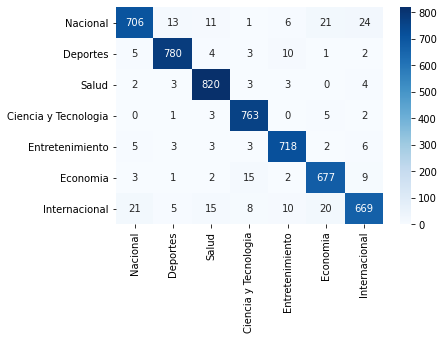

In [13]:
confusion_matrix = { i : {} for i in categories }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { i : 0 for i in categories } # {'Deportes': {'Deportes': 700, 'Entretenimiento': 3, ...}, ...}

for i in range(len(test)):
    row = test.iloc[i]
    category = row['categoria']
    title = row['titular']
    result = classify(title)
    confusion_matrix[category][result] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

import seaborn as sns
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')

In [14]:
import numpy as np

true = []
predicted = []

for i in range(len(test)):
    row = test.iloc[i]
    true.append(row['categoria'])
    title = row['titular']
    predicted.append(classify(title))

    
# Calculamos las metricas para cada categoria    
    
category_metrics = { i : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'accuracy': 0, 'precision': 0, 'recall': 0,  'f1': 0} for i in categories }

for i, category in enumerate(categories):
    
    # Metricas simples
    tp = confusion_df.iloc[i,i]
    tn = sum(np.diag(confusion_df)) - tp
    fn = sum(confusion_df.loc[category]) - tp
    fp = sum(confusion_df[category]) - tp
    
    category_metrics[category]['tp'] = tp
    category_metrics[category]['tn'] = tn
    category_metrics[category]['fp'] = fp
    category_metrics[category]['fn'] = fn
    
    # Metricas compuestas
    category_metrics[category]['accuracy'] = (tp + tn) / (tp + tn + fn + fp)
    category_metrics[category]['precision'] = tp / (tp + fp)
    category_metrics[category]['recall'] = tp / (tp + fn)
    category_metrics[category]['f1'] = (2 * category_metrics[category]['precision'] * category_metrics[category]['recall']) / (category_metrics[category]['precision'] + category_metrics[category]['recall'])

metric_cols = ['tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'f1']
metrics_df = { key : list(category_metrics[key].values()) for key in category_metrics.keys() }    
metrics_df = pd.DataFrame.from_dict(category_metrics, orient='index', columns=metric_cols)
metrics_df.head()

# Calculamos las metricas para el classifier en general (checkear cual es la forma correcta)
    
tp, fp, fn = 0, 0, 0


for i, category in enumerate(categories):
    tp += confusion_df.iloc[i, i]
    fp += sum(confusion_df.iloc[i, :i])
    fn += sum(confusion_df.iloc[i, i+1:])
    
tn = confusion_df.to_numpy().sum() - (fp + fn + tp)

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

metrics_df

    



,tp,tn,fp,fn,accuracy,precision,recall,f1
Nacional,706,4427,36,76,0.978646,0.951482,0.902813,0.926509
Deportes,780,4353,26,25,0.990162,0.967742,0.968944,0.968343
Salud,820,4313,38,15,0.989780,0.955711,0.982036,0.968695
Ciencia y Tecnologia,763,4370,33,11,0.991501,0.958543,0.985788,0.971975
Entretenimiento,718,4415,31,22,0.989780,0.958611,0.970270,0.964406
Economia,677,4456,49,32,0.984465,0.932507,0.954866,0.943554
Internacional,669,4464,47,79,0.976041,0.934358,0.894385,0.913934


In [15]:
# Calcular cantidad total de apariciones de palabras
totalCount = 0
uniqueWords = set({})
for category in categories:
    for key in categories_word_appearances[category].keys():
        totalCount += categories_word_appearances[category][key]
        uniqueWords.add(key)
        
print(totalCount)
print(len(uniqueWords))

273748
14313


In [16]:
# Calcular probabilidades para la curva ROC
def classify_with_prob(title):
    words = split_and_sanitize(title)
    
    vs = {}
    denom = 0 # P([word])
    for category in categories:
        v = category_relative_freq.loc[category]
        aux = category_relative_freq[category]
        
        for word in words:
            aux *= word_relative_frequencies[category][word] if word in word_relative_frequencies[category] else zero_probabilities[category]
            
            if word in word_relative_frequencies[category]:
                v *= word_relative_frequencies[category][word]
            else:
                v *= zero_probabilities[category]
                
        vs[category] = v
        denom += aux
        
    for k in vs.keys():
        vs[k] /= denom
        
    return vs

In [17]:
print(classify_with_prob("Messi metió ocho goles"))
print(sum(classify_with_prob("Messi metió ocho goles").values()))

{'Nacional': 0.001022024254511572, 'Deportes': 0.997236962010836, 'Salud': 5.618745765908239e-05, 'Ciencia y Tecnologia': 4.801185105436759e-05, 'Entretenimiento': 0.0004486977612415312, 'Economia': 0.00025431662034281865, 'Internacional': 0.0009338000443545974}
1.0


In [18]:
for index, category in enumerate(categories):
    test.insert(index + 2, f"prob_{category}", 0)

In [26]:
import matplotlib.pyplot as plt

#classification_probs = []
u = [0.1 * x for x in range(1, 10)]

category_metrics = { cat : { threshold : {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0} for threshold in u} for cat in categories }
titular_classifications = {}


for i in range(len(test)):
    row = test.iloc[i]
    fmt = {'categoria_real': row['categoria']}
    category = row['categoria']
    title = row['titular']
    vs = classify_with_prob(title)
    
    for cat, v in vs.items():
        fmt[f"prob_{cat}"] = v
    titular_classifications[row['titular']] = fmt
        
for category in categories:
    records = test.query(f"categoria == '{category}'")
    for index, record in records.iterrows():
        prob = titular_classifications[record['titular']][f"prob_{category}"]
        for threshold in u:
            if prob >= threshold:
                category_metrics[category][threshold]['tp'] += 1
            else:
                category_metrics[category][threshold]['fn'] += 1

    records = test.query(f"categoria != '{category}'")
    for index, record in records.iterrows():
        real_category = titular_classifications[record['titular']]['categoria_real']
        try:
            prob = titular_classifications[record['titular']][f"prob_{real_category}"]
        except:
            print(record)
        for threshold in u:
            if prob >= threshold:
                category_metrics[category][threshold]['fp'] += 1
            else:
                category_metrics[category][threshold]['tn'] += 1
    
print(category_metrics)

{'Nacional': {0.1: {'tp': 738, 'tn': 101, 'fp': 4510, 'fn': 44}, 0.2: {'tp': 727, 'tn': 135, 'fp': 4476, 'fn': 55}, 0.30000000000000004: {'tp': 722, 'tn': 161, 'fp': 4450, 'fn': 60}, 0.4: {'tp': 712, 'tn': 187, 'fp': 4424, 'fn': 70}, 0.5: {'tp': 703, 'tn': 217, 'fp': 4394, 'fn': 79}, 0.6000000000000001: {'tp': 697, 'tn': 247, 'fp': 4364, 'fn': 85}, 0.7000000000000001: {'tp': 688, 'tn': 281, 'fp': 4330, 'fn': 94}, 0.8: {'tp': 667, 'tn': 318, 'fp': 4293, 'fn': 115}, 0.9: {'tp': 631, 'tn': 399, 'fp': 4212, 'fn': 151}}, 'Deportes': {0.1: {'tp': 796, 'tn': 136, 'fp': 4452, 'fn': 9}, 0.2: {'tp': 789, 'tn': 174, 'fp': 4414, 'fn': 16}, 0.30000000000000004: {'tp': 785, 'tn': 201, 'fp': 4387, 'fn': 20}, 0.4: {'tp': 779, 'tn': 231, 'fp': 4357, 'fn': 26}, 0.5: {'tp': 768, 'tn': 259, 'fp': 4329, 'fn': 37}, 0.6000000000000001: {'tp': 761, 'tn': 288, 'fp': 4300, 'fn': 44}, 0.7000000000000001: {'tp': 755, 'tn': 325, 'fp': 4263, 'fn': 50}, 0.8: {'tp': 748, 'tn': 376, 'fp': 4212, 'fn': 57}, 0.9: {'tp': 

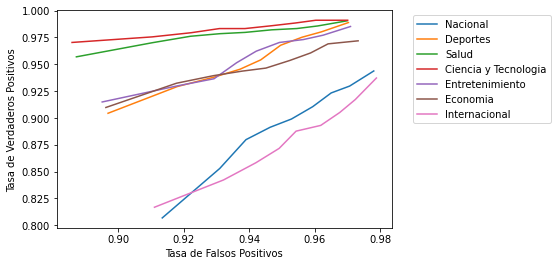

In [33]:
for c, thresholds in category_metrics.items():
    x = []
    y = []
    for threshold, values in thresholds.items():
        TPR = float(values['tp']) / (values['tp'] + values['fn'])
        FPR = float(values['fp']) / (values['fp'] + values['tn'])
        x.append(FPR)
        y.append(TPR)
    # print(x)
    # print(y)
    plt.plot(x,y, label=c)
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.show()